# Projeto PAS - Notebook 02: EDA e Modelagem Mestre (Backtest)

**Pesquisador:** Luiz Henrique Tomaz Moreira

## Objetivo
Este *notebook* é o "laboratório de pesquisa". O objetivo é usar o **Dataset Mestre** (`PAS_MESTRE_LIMPO_FINAL.csv`), que contém 7 triênios (48.758 alunos), para:

1.  **Análise:** Validar a estabilidade das descobertas estatísticas ao longo do tempo.
2.  **Modelagem:** Construir e validar (backtest) um modelo de regressão robusto que prove a **Hipótese H2 (Dependência Temporal)**.
3.  **Baseline (Fases Futuras):** Usar este *dataset* como *baseline* para testar o enriquecimento com dados do Vestibular Tradicional e de Cotas (H3 e H4).

**Input:** `PAS_MESTRE_LIMPO_FINAL.csv` (48.758 alunos)

**Output:** Um modelo de ML validado (`modelo_lgbm_v1.joblib`) e um relatório de `Feature Importance`.

**Célula 1: Setup e Carregamento de Dados**

**Objetivo**: Importar todas as bibliotecas de análise e modelagem (Pandas, Scikit-learn, etc.) e carregar o dataset mestre (PAS_MESTRE_LIMPO_FINAL.csv), que foi o produto final do Notebook 01 (Parser).

**Dataset**: Contém 48.758 observações (alunos "sobreviventes") de 7 triênios (2016-2024).

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import joblib

print("Montando o Google Drive...")
drive.mount('/content/drive')

caminho_modelos = '../models/'
caminho_mestre_csv = '../data/PAS_MESTRE_LIMPO_FINAL.csv'

try:
    df_mestre = pd.read_csv(caminho_mestre_csv)
    print(f"DataFrame 'Mestre' (com {len(df_mestre)} alunos) carregado.")
except FileNotFoundError:
    print(f"ERRO: Não achei o arquivo {caminho_mestre_csv}.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

Montando o Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DataFrame 'Mestre' (com 48758 alunos) carregado.


**Célula 2: Análise Exploratória (EDA) e Engenharia de Atributos**

**Objetivo**: Preparar o dataset para a modelagem e validar as hipóteses estatísticas iniciais.

1. Engenharia de Atributos (H2): Novas features (atributos) foram criadas para testar a Hipótese H2 (Dependência Temporal). Isso inclui os Escores Brutos (EB_PAS1, EB_PAS2, EB_PAS3) e as features de "Crescimento" (Cresc_EB, Cresc_Red).

2. Análise Estatística (.describe()): A análise de distribuição confirmou padrões estáveis ao longo dos 7 triênios, como o min=0.0 para notas do PAS 1 (indicando "faltosos", conforme o edital) e a assimetria positiva (Média > Mediana) nas notas do PAS 3.

3. Análise de Correlação (.heatmap()): O mapa de calor de correlação foi gerado para identificar relações lineares e validar o escopo do modelo.

    • Descoberta 1 (Target Leakage): A correlação de 0.93 entre EB_PAS3 e Arg_Final confirma que o Arg_Final não pode ser usado como alvo preditivo se dados do PAS 3 forem usados como features, validando a mudança de foco.

    • Descoberta 2 (Validação H2): A correlação de 0.86 entre EB_PAS2 (passado) e EB_PAS3 (futuro) confirma um sinal preditivo forte e estável.

        EB_PAS1  Red_PAS1   EB_PAS2  Red_PAS2  Cresc_EB  Cresc_Red   EB_PAS3  Arg_Final
count 48758.000 48758.000 48758.000 48758.000 48758.000  48758.000 48758.000  48758.000
mean     28.187     6.090    29.770     7.025     1.584      0.935    30.665      1.593
std      15.333     2.658    14.046     1.855    12.326      2.719    14.307     50.471
min       0.000     0.000   -22.816     0.000   -47.354     -9.652     0.472   -136.768
25%      18.603     5.033    19.891     5.883    -6.672     -0.773    20.230    -35.304
50%      28.231     6.564    28.318     7.083     0.627      0.576    28.956     -4.865
75%      38.178     8.000    38.133     8.500     8.672      2.209    39.133     31.638
max      85.728    10.000    87.922    10.000    72.849     10.000    92.316    220.005


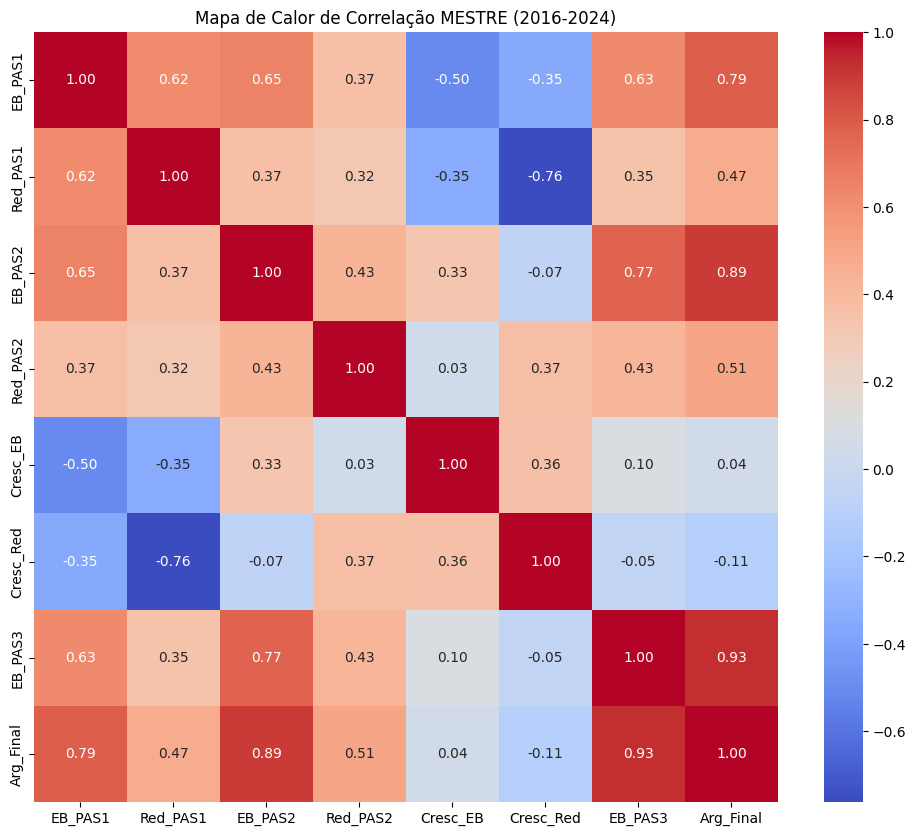

In [15]:
df_mestre['EB_PAS1'] = df_mestre['P1_PAS1'] + df_mestre['P2_PAS1']
df_mestre['EB_PAS2'] = df_mestre['P1_PAS2'] + df_mestre['P2_PAS2']
df_mestre['EB_PAS3'] = df_mestre['P1_PAS3'] + df_mestre['P2_PAS3']

df_mestre['Cresc_EB'] = df_mestre['EB_PAS2'] - df_mestre['EB_PAS1']
df_mestre['Cresc_Red'] = df_mestre['Red_PAS2'] - df_mestre['Red_PAS1']

colunas_analise = [
    'EB_PAS1', 'Red_PAS1', 'EB_PAS2', 'Red_PAS2',
    'Cresc_EB', 'Cresc_Red', 'EB_PAS3', 'Arg_Final'
]
print(df_mestre[colunas_analise].describe().to_string(float_format="%.3f"))

corr_matrix_mestre = df_mestre[colunas_analise].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_mestre, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mapa de Calor de Correlação MESTRE (2016-2024)')
plt.show()



**Célula 3: Preparação da Modelagem (Split e Pré-processamento)**

**Objetivo**: Preparar os dados para um treinamento e avaliação justos (sem overfitting ou viés de escala).

1. Definição de X e y: O dataset é dividido em X (features, 6 colunas) e y (alvo, EB_PAS3).

2. Divisão Treino/Teste: O dataset mestre é dividido (split 80/20) em conjuntos de Treino (39.006 amostras) e Teste (9.752 amostras) usando train_test_split.

3. Padronização (StandardScaler): Os dados de features (X) são padronizados (Z-score, média=0, std=1) para X_train_scaled e X_test_scaled. Esta etapa é essencial para o desempenho de modelos matemáticos sensíveis à escala, como a Regressão Linear e o MLP.

In [16]:
y = df_mestre['EB_PAS3']

feature_names = [
    'EB_PAS1', 'Red_PAS1', 'EB_PAS2', 'Red_PAS2', 'Cresc_EB', 'Cresc_Red'
]
X = df_mestre[feature_names]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"Dados divididos: {len(X_train)} para Treino, {len(X_test)} para Teste.")

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dados padronizados (scaled) criados.")

Dados divididos: 39006 para Treino, 9752 para Teste.
Dados padronizados (scaled) criados.


**Célula 4: Treinamento e Avaliação (O "Campeonato" de Modelos)**

**Objetivo**: Comparar objetivamente a performance das 4 principais famílias de modelos de regressão neste dataset.

1. Modelos Baseados em Árvore: (RandomForest, LGBM) são treinados nos dados originais (X_train), pois são robustos a diferenças de escala.

2. Modelos Baseados em Gradiente/Matemáticos: (LinearRegression, MLPRegressor) são treinados nos dados padronizados (X_train_scaled) para garantir a correta convergência.

3. Avaliação: Todos os modelos são avaliados no dataset de Teste "cego" (X_test / X_test_scaled). As métricas de performance (R² e MAE) são comparadas.

In [17]:
print("Treinando Modelo 1: Linear...")
modelo_linear = LinearRegression()
modelo_linear.fit(X_train_scaled, y_train)

print("Treinando Modelo 2: Random Forest...")
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
modelo_rf.fit(X_train, y_train)

print("Treinando Modelo 3: LightGBM...")
modelo_lgbm = LGBMRegressor(random_state=42, n_jobs=-1)
modelo_lgbm.fit(X_train, y_train)

print("Treinando Modelo 4: Rede Neural (MLP)...")
modelo_mlp = MLPRegressor(hidden_layer_sizes=(100, 50), random_state=42, max_iter=500)
modelo_mlp.fit(X_train_scaled, y_train)
print("...Todos os modelos treinados.")

y_pred_linear = modelo_linear.predict(X_test_scaled)
y_pred_rf = modelo_rf.predict(X_test)
y_pred_lgbm = modelo_lgbm.predict(X_test)
y_pred_mlp = modelo_mlp.predict(X_test_scaled)

print("\n--- PLACAR FINAL (R² e MAE) ---")
print(f"1. LightGBM (O Vencedor): R² = {r2_score(y_test, y_pred_lgbm):.4f} | MAE = {mean_absolute_error(y_test, y_pred_lgbm):.4f}")
print(f"2. Rede Neural (MLP):    R² = {r2_score(y_test, y_pred_mlp):.4f} | MAE = {mean_absolute_error(y_test, y_pred_mlp):.4f}")
print(f"3. Regressão Linear:     R² = {r2_score(y_test, y_pred_linear):.4f} | MAE = {mean_absolute_error(y_test, y_pred_linear):.4f}")
print(f"4. Random Forest:        R² = {r2_score(y_test, y_pred_rf):.4f} | MAE = {mean_absolute_error(y_test, y_pred_rf):.4f}")

Treinando Modelo 1: Linear...
Treinando Modelo 2: Random Forest...
Treinando Modelo 3: LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 39006, number of used features: 6
[LightGBM] [Info] Start training from score 30.656299
Treinando Modelo 4: Rede Neural (MLP)...
...Todos os modelos treinados.

--- PLACAR FINAL (R² e MAE) ---
1. LightGBM (O Vencedor): R² = 0.6445 | MAE = 6.8123
2. Rede Neural (MLP):    R² = 0.6393 | MAE = 6.8423
3. Regressão Linear:     R² = 0.6302 | MAE = 6.9371
4. Random Forest:        R² = 0.6225 | MAE = 6.9965


**Célula 5: Análise do Modelo Vencedor (Feature Importance)**

**Objetivo**: Analisar "por que" o modelo vencedor (LightGBM) teve a melhor performance, validando as hipóteses de features.

**Análise dos Resultados**:

• **Vencedor**: O LightGBM (LGBM) foi o campeão (R² = 0.6445), superando o MLP (0.6393), Linear (0.6302) e o RF (0.6225). Um R² de 64,45% é um resultado robusto.

• **Análise de Feature Importance (LGBM)**: O LGBM (o vencedor) usou uma estratégia de "time" equilibrada, onde EB_PAS1 (20.9%), EB_PAS2 (19.6%) e Red_PAS2 (18.7%) foram todas cruciais.

• **Diagnóstico (RF)**: O RandomForest (o perdedor) demonstrou uma estratégia "gananciosa" e superestimou o EB_PAS2 (66,2%), provando ser uma estratégia de modelagem inferior para este problema.

--- Análise do Modelo Vencedor (LightGBM) ---
Importância (LGBM - Vencedor):
EB_PAS1      20.866667
EB_PAS2      19.633333
Red_PAS2     18.666667
Cresc_Red    14.233333
Red_PAS1     13.600000
Cresc_EB     13.000000
dtype: float64


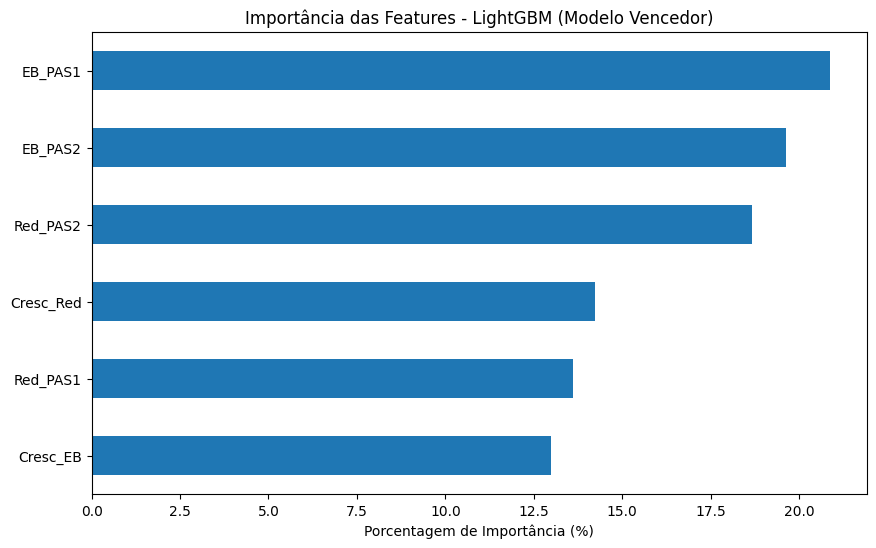


--- Análise do Contender (Random Forest) ---
Importância (Random Forest):
EB_PAS2      0.662002
EB_PAS1      0.087428
Red_PAS2     0.075629
Cresc_EB     0.060671
Cresc_Red    0.060476
Red_PAS1     0.053795
dtype: float64


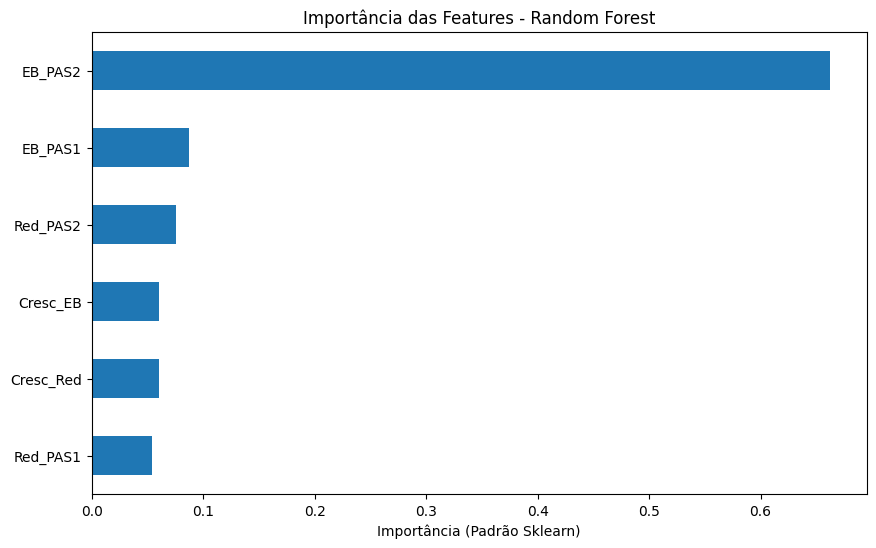

In [18]:
print("--- Análise do Modelo Vencedor (LightGBM) ---")

importancias_lgbm = pd.Series(modelo_lgbm.feature_importances_, index=X_train.columns)
importancias_lgbm_percent = (importancias_lgbm / importancias_lgbm.sum() * 100)

print("Importância (LGBM - Vencedor):")
print(importancias_lgbm_percent.sort_values(ascending=False))

plt.figure(figsize=(10, 6))
importancias_lgbm_percent.sort_values().plot(kind='barh')
plt.title('Importância das Features - LightGBM (Modelo Vencedor)')
plt.xlabel('Porcentagem de Importância (%)')
plt.show()

print("\n--- Análise do Contender (Random Forest) ---")

importancias_rf = pd.Series(modelo_rf.feature_importances_, index=X_train.columns)

print("Importância (Random Forest):")
print(importancias_rf.sort_values(ascending=False))

plt.figure(figsize=(10, 6))
importancias_rf.sort_values().plot(kind='barh')
plt.title('Importância das Features - Random Forest')
plt.xlabel('Importância (Padrão Sklearn)')
plt.show()

**Célula 6: Serialização de "Artefatos" e Função de Demonstração**

**Objetivo**: Salvar os produtos finais do pipeline (o modelo e o scaler) e criar uma função de "demo" para encapsular a lógica do projeto.

1. **Serialização (joblib.dump)**: O modelo vencedor (modelo_lgbm_v1.joblib) e o StandardScaler (scaler_v1.joblib) são serializados (salvos em disco) para uso futuro (ex: deployment em um app web).

2. **Encapsulamento (def prever_pas3)**: Uma função de demonstração é criada. Ela serve como uma "API" para o modelo, encapsulando a lógica de feature engineering da H2 (cálculo de Cresc_EB e Cresc_Red) antes de alimentar o modelo treinado (.predict()).

In [19]:
# Salva o modelo VENCEDOR (LGBM)
joblib.dump(modelo_lgbm, caminho_modelos + 'modelo_lgbm_v1.joblib')

# Salva o SCALER (que foi essencial para o Linear e o MLP)
joblib.dump(scaler, caminho_modelos + 'scaler_v1.joblib')

print("Modelo vencedor (LGBM) e Scaler foram salvos no Google Drive.")

Modelo vencedor (LGBM) e Scaler foram salvos no Google Drive.


In [21]:
def prever_pas3(eb_pas1, red_pas1, eb_pas2, red_pas2):

    cresc_eb = eb_pas2 - eb_pas1
    cresc_red = red_pas2 - red_pas1

    features_array = np.array([[
        eb_pas1, red_pas1, eb_pas2, red_pas2, cresc_eb, cresc_red
    ]])

    pred_rf = modelo_rf.predict(features_array)
    pred_lgbm = modelo_lgbm.predict(features_array)

    features_scaled = scaler.transform(features_array)
    pred_linear = modelo_linear.predict(features_scaled)
    pred_mlp = modelo_mlp.predict(features_scaled)

    print(f"\n--- PREVISÃO PARA O ALUNO ---")
    print(f"Dados de Entrada: EB1={eb_pas1}, Red1={red_pas1}, EB2={eb_pas2}, Red2={red_pas2}")
    print(f"Features H2: Cresc_EB={cresc_eb:.3f}, Cresc_Red={cresc_red:.3f}\n")

    print(f"Previsão (LightGBM - Vencedor): {pred_lgbm[0]:.4f}")
    print(f"Previsão (Rede Neural - MLP):   {pred_mlp[0]:.4f}")
    print(f"Previsão (Regressão Linear):  {pred_linear[0]:.4f}")
    print(f"Previsão (Random Forest):     {pred_rf[0]:.4f}")


# --- ÁREA DE TESTE (COLOQUE AS NOTAS AQUI) ---

print("TESTE")
prever_pas3(eb_pas1=46.224, red_pas1=6.133, eb_pas2=58.640, red_pas2=9.643)

TESTE

--- PREVISÃO PARA O ALUNO ---
Dados de Entrada: EB1=46.224, Red1=6.133, EB2=58.64, Red2=9.643
Features H2: Cresc_EB=12.416, Cresc_Red=3.510

Previsão (LightGBM - Vencedor): 54.3204
Previsão (Rede Neural - MLP):   53.7525
Previsão (Regressão Linear):  53.8827
Previsão (Random Forest):     54.2400


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
